In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import bisect
from collections import OrderedDict
import seaborn as sns
%matplotlib inline

C:\Users\acer\AppData\Local\Temp\ipykernel_2292\228214236.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#Let p1 be point -> [x1,y1]
#Let p2 be point -> [x2,y2]
def distance_between_two_points(p1,p2):
  return ((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)**0.5


In [3]:
#this function takes array and target element as input and returns index of element which is greater than previous one
def search(arr, target):
  arr1 = sorted(arr)
  pos = bisect.bisect_right(arr1, target)
  if pos==len(arr1):
    return target
  else:
    return arr1[pos]

In [4]:
# This function calculates outlier range of an array using IQR values
# This returns a 1d array of lower boundary and upper boundary
def outlier_range(array):
  q1 = np.percentile(array,25)
  q3 = np.percentile(array,75)

  IQR = q3 - q1

  lower_bound = q1 - (1.5*IQR)
  upper_bound = q1 + (1.5*IQR)

  return [lower_bound,upper_bound]

In [5]:
#points array should be 2d that is in format of [[x,y],[a,b]...]
#centroid array should be 1d
#if some set of points are mapped to a centroid point then this process will be easy
#let dic = {0 : [[p1,p2],[p3,p4]] , 1 : [[p5,p6],[p7,p8]] , ....}
#let centroids array be [[c1,c2],[c3,c4],....]
#returned array will be nested list

def distance_from_centroid(dic,centroid):
  distances = []
  for i in dic.keys():
    temparr=[]
    for j in dic[i]:
      temparr.append(distance_between_two_points(j,centroid[i]))
    distances.append(temparr)
  print(temparr)
  return distances

In [6]:
#distances array should be 2d -> [[distances array of cluster 1],[distances array of cluster 2]....]
def mean(distances):
  mean_of_distances=[]
  for i in distances:
    l = len(i)
    s = sum(i)

    mean = s/l
    mean_of_distances.append(mean)
  return mean_of_distances

In [7]:
#(standard deviation)^2 = sum((occurences - mean)*(occurences-mean))/total number of ocurences
def standard_deviation(distances,mean_of_distances):
  ind = 0
  stddev=[]
  for i in distances:
    temp = 0
    for j in i:
      sq = (mean_of_distances[ind] - j)**2
      temp+=sq
    ind += 1
    stddev.append((temp/len(i))**0.5)
    temp = 0
  return stddev

In [8]:
#this returns treshhold values of all clusters
def treshhold(stddev,mean_of_distances):
  # ran = random.uniform(0,1)
  # ran =int(input("please enter value for alpha which should be in between 0 to 1 "))
  ran=0.5
  tresh = []

  for i,j in zip(mean_of_distances,stddev):
    temp = i + (ran * j)
    tresh.append(temp)
  return tresh

In [9]:
#In this we take parameters as distances array from distances_from_centroid function
#Another parameter is tresh 1d array from treshhold function
#this function returns avg cutoff distance of each cluster
def avg_cutoff_distance(distances,tresh):
  avg_co = {}
  cn = 0
  for i,j in zip(distances,tresh):
    temparr = [k for k in i if k<=j]
    s = sum(temparr)
    l = len(temparr)
    print("hi")
    temp = s/l
    avg_co[cn] = temp
    cn+=1
  return avg_co

In [10]:
#this function returns local density of a point
#this function takes point, dictionary of points denoting clusters,avg cutoff distance of that cluster
#this returns local densities array

def local_density(dic,avg_co,ind):
  temp = []
  maxi = 0
  for i in dic[ind]:
    cn = 0
    for j in dic[ind]:
      d = distance_between_two_points(i,j)
      maxi = max(d,maxi)
      if d < avg_co[ind]:
        cn+=1
    temp.append(cn)
  temp.append(maxi)
  return temp

In [11]:
#this function takes arguments as local_density of points, clusters, maxi array.
def closest_distance_to_the_highest_density_points(local_densities,clusters,maxi,i):

  arr_of_req=[]
  for j in range(len(clusters[i])):

    req_element = search(local_densities[i],local_densities[i][j])
    req_index = local_densities[i].index(req_element)

    temp =  distance_between_two_points(clusters[i][j],clusters[i][req_index])

    if temp==0:
      arr_of_req.append(maxi[i])
    else:
      arr_of_req.append(temp)

  return arr_of_req

In [12]:
# this function takes keys of clusters dictionary,local density array, closest distance array
# this function returns a dictionary conataining all clusters and their valuesas a 2d array of [[local_density,closest_distance]....]
def ordered_pairs(clusters_keys,local_density,closest_distance):
  pairs = OrderedDict()

  for i in clusters_keys:
    for j,k in zip(local_density[i],closest_distance[i]):
      if i not in pairs.keys():
        pairs[i] = [[j,k]]
      else:
        pairs[i].append([j,k])
  return pairs

In [13]:
# This function takes inputs as merge_pop array,local_densities 2d array,closest_distance_points 2d array
def outlier_selection_strategy_1(Merge_POP,local_Densities,closest_distance_points):
  final = []
  for i in Merge_POP:
    var = local_Densities[i[0]][i[1]]/closest_distance_points[i[0]][i[1]]
    final.append(var)
  return final

In [14]:
# this function takes input as :
# merge_pop = probable outliers 2d array of format => [[cluster number,index of point in main clusters array]...]
# local_densities = local densities 2d array
# closest_distance_points = 2d array of relative distances
# std_dev,mean = 2d arrays of standard deviation and mean

# this returns final 1d array of odf factors


from math import exp,pi
def outlier_selection_strategy_2(merge_pop,local_densities,closest_distance_points,std_dev,mean):
  final = []
  for i in merge_pop:
    var = (local_densities[i[0]][i[1]] - mean[i[0]])**2
    var /= (2*(std_dev[i[0]]**2))
    var *= -1

    var_new = exp(var)
    denom = (2*pi*(std_dev[i[0]]**2))
    func = var_new/denom

    odf = closest_distance_points[i[0]][i[1]]*func

    final.append(odf)
  return final



# **Prerequisites before entering into orginal process**


In [15]:
# Here mention name of dataset else mention its location to read it
df = pd.read_csv("apartment_cost_list.csv")
print(df)

           Job #    Borough House #          Street Name  Block  Lot    Bin #  \
0      123768976  MANHATTAN    1598           2ND AVENUE   1545   49  1049907   
1      140922893  MANHATTAN     160              E 89 ST   1517   43  1048094   
2      301773579   BROOKLYN      65         GATES AVENUE   1962   86  3056039   
3      301976057   BROOKLYN    1401         OCEAN AVENUE   7584   35  3206621   
4      301989276   BROOKLYN     154         NOBLE STREET   2573   10  3065099   
...          ...        ...     ...                  ...    ...  ...      ...   
19608  122923649  MANHATTAN     315     WEST 33RD STREET    757   22  1013552   
19609  121090112  MANHATTAN     110         DUANE STREET    150   22  1001645   
19610  102937342  MANHATTAN     166          BANK STREET    638    4  1078335   
19611  200838558      BRONX    2762  KINGSBRIDGE TERRACE   3253   90  2015521   
19612  301429158   BROOKLYN     802        HOWARD AVENUE   3565   42  3081797   

      Job Type  Community -

In [16]:
#This step indicates conversion of df from csv file to dataframe
df = pd.DataFrame(df)


In [17]:
# checking of null values
df.isnull().sum()

Job #                         0
Borough                       0
House #                       0
Street Name                   0
Block                         0
Lot                           0
Bin #                         0
Job Type                      0
Community - Board             0
Curb Cut                  19597
Fully Permitted            3988
Initial Cost                  0
Proposed Zoning Sqft          0
Horizontal Enlrgmt        19450
Vertical Enlrgmt          19371
Enlargement SQ Footage        0
Zoning Dist1               2096
Job Description               0
dtype: int64

In [18]:
# checking datatypes using info method
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19613 entries, 0 to 19612
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Job #                   19613 non-null  int64 
 1   Borough                 19613 non-null  object
 2   House #                 19613 non-null  object
 3   Street Name             19613 non-null  object
 4   Block                   19613 non-null  int64 
 5   Lot                     19613 non-null  int64 
 6   Bin #                   19613 non-null  int64 
 7   Job Type                19613 non-null  object
 8   Community - Board       19613 non-null  int64 
 9   Curb Cut                16 non-null     object
 10  Fully Permitted         15625 non-null  object
 11  Initial Cost            19613 non-null  object
 12  Proposed Zoning Sqft    19613 non-null  int64 
 13  Horizontal Enlrgmt      163 non-null    object
 14  Vertical Enlrgmt        242 non-null    object
 15  En

In [19]:
# Forming new dataframe using given data frames
dfnew1 = list(df['Block'][:500])
dfnew2 = list(df['Lot'][:500])

dfnew = []

for i,j in zip(dfnew1,dfnew2):
  dfnew.append([i,j])
print(dfnew)


[[1545, 49], [1517, 43], [1962, 86], [7584, 35], [2573, 10], [321, 7501], [4056, 145], [1961, 6], [1656, 59], [3157, 39], [899, 32], [460, 2], [1385, 37], [3208, 11], [1656, 67], [489, 20], [1499, 32], [1251, 71], [5090, 49], [7264, 69], [1065, 37], [1349, 7501], [1497, 28], [1581, 39], [1169, 57], [1515, 1], [1164, 159], [460, 34], [642, 52], [1876, 7], [1879, 36], [1253, 7503], [1870, 7502], [825, 71], [1030, 58], [2706, 9], [1865, 48], [572, 54], [6272, 31], [1515, 7502], [1370, 46], [321, 39], [385, 54], [1217, 137], [952, 68], [336, 16], [934, 56], [2698, 17], [302, 53], [936, 7501], [2842, 1], [3279, 3], [941, 7501], [6133, 25], [247, 25], [1078, 31], [1075, 12], [7023, 59], [6236, 78], [949, 10], [7423, 11], [5980, 1], [958, 24], [2690, 57], [321, 7501], [3283, 104], [616, 11], [5784, 43], [3378, 20], [3311, 44], [874, 69], [237, 17], [3051, 9], [1962, 9], [1329, 12], [5660, 65], [4721, 17], [311, 22], [178, 54], [1510, 1], [1449, 38], [100, 3], [8472, 1], [3380, 2], [448, 37], 

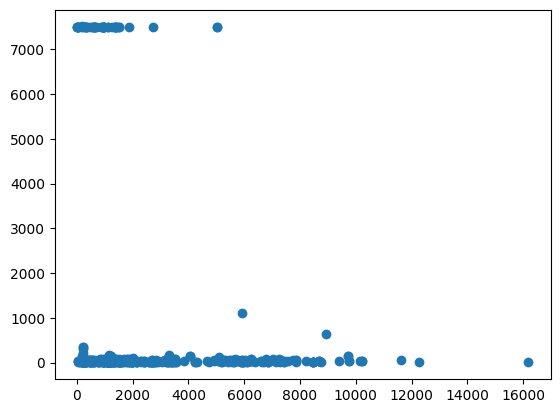

In [20]:
#from our dataset contating 19613 rows and 18 columns we take only 100 rows
# plt.scatter(df['Block'][:500],df['Lot'][:500])
plt.scatter(dfnew1,dfnew2)
plt.show()

In [21]:
# This snippet tries all clusters and gives us best fit
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(dfnew)
    wcss.append(kmeans.inertia_)
# print(wcss)

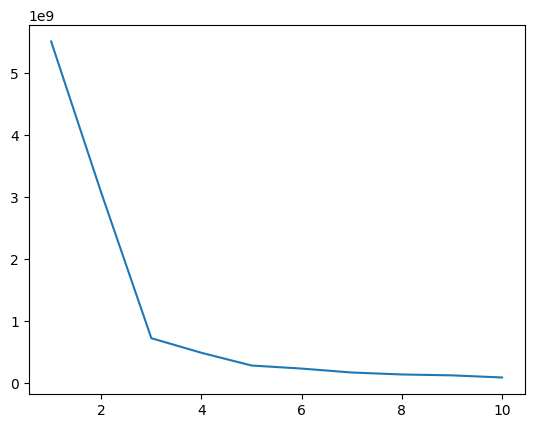

In [22]:
# plotting graph to see elbow curve
import matplotlib.pyplot as plt

plt.plot(range(1,11),wcss)
plt.show()

In [23]:
# from above we can say that no. of clusters should be 3
# In this step we will store them

df1 = np.array(dfnew)
# print(df1)
kmeans = KMeans(n_clusters=3).fit(df1)
# print(kmeans)
temp_clusters = OrderedDict()
for i, label in enumerate(kmeans.labels_):
    if label not in temp_clusters:
        temp_clusters[label] = []
    else:
      temp = list(df1[i])
      temp_clusters[label].append(temp)
# print(temp_clusters)
clusters = OrderedDict()

for i in sorted(temp_clusters.keys()):
  clusters[i] = temp_clusters[i]

# print(clusters)

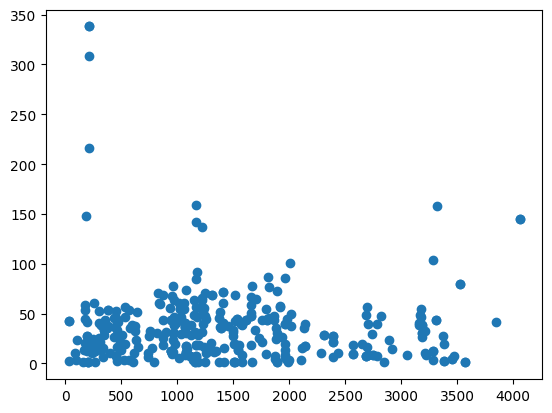

In [24]:
# plotting of cluster - 0
plt.scatter([i[0] for i in clusters[0]],[i[1] for i in clusters[0]])

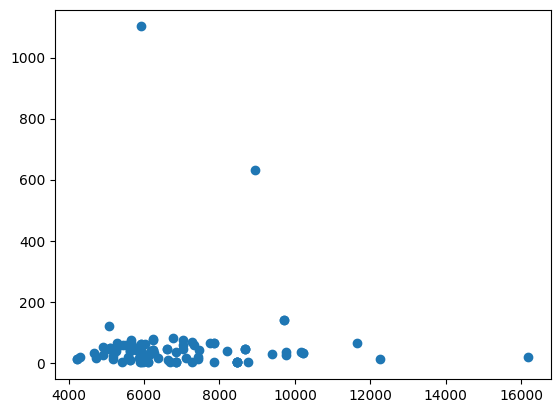

In [25]:
# plotting of cluster - 1
plt.scatter([i[0] for i in clusters[1]],[i[1] for i in clusters[1]])

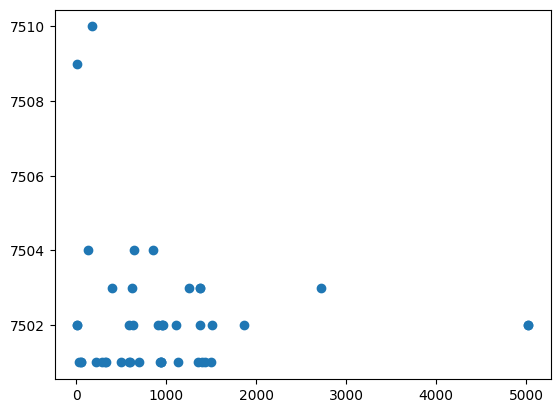

In [26]:
# .plotting of cluster - 2
plt.scatter([i[0] for i in clusters[2]],[i[1] for i in clusters[2]])


# This is Main() Function

In [27]:
#step 1 : get centroid of clusters for this we can use bruteforce

centroid = np.array(kmeans.cluster_centers_)
print(centroid)



[[1410.88920455   36.32670455]
 [6860.5          52.35294118]
 [ 980.76086957 7502.13043478]]


In [28]:
#step 2 : calculate distances from centroid and store it in distances array

distances = distance_from_centroid(clusters,centroid)
print(distances)

[368.240865556992, 272.24051918029016, 889.2391400009567, 534.2391463576452, 44.77514184268011, 39.7769359224658, 659.7618380084206, 965.7608783734187, 965.7608783734187, 964.7853265729689, 19.76130003835891, 800.7995381389487, 400.24007504853677, 516.2403681182423, 396.76247995613835, 455.2405339617891, 845.7629359116031, 379.76255204499523, 134.23919380389293, 20.761279303946527, 390.7608913345823, 952.7615401859306, 929.7615567754276, 339.766013252966, 395.2391519574898, 130.7742340201381, 1740.2393476875748, 20.761279303946527, 423.24064007841775, 147.24346985176862, 38.77735024791555, 482.7621930787067, 400.24007504853677, 349.7608938864513, 68.7609932781467, 286.76309768970845, 755.7617149927423, 929.7615567754276, 38.77735024791555, 577.7615239390931, 694.7617892211795, 649.7618529130076, 4041.2391325397352, 4041.2391325397352, 356.7619292982328]
[[106.32042975938383, 553.3448699932588, 1162.4089625791005, 2647.3422531616748, 550.9460919946891, 246.1572269406876, 1746.1128418608

In [29]:
#step 3 : calculate mean of distances

avg_distances = mean(distances)
print(avg_distances)

[757.4978273099279, 1401.726478577415, 641.2797697035666]


In [30]:
#step 4 : calculate standard deviation of distances

std_dev = standard_deviation(distances,avg_distances)
print(std_dev)

[564.6708881842994, 1242.0854079477162, 814.3149468202175]


In [31]:
#step 5 : calculate tresh hold values from mean and standard deviation

tresh = treshhold(std_dev,avg_distances)
print(tresh)

[1039.8332714020776, 2022.7691825512732, 1048.4372431136753]


In [32]:
#step 6 : calculate average cutoff distance

avg_cd = avg_cutoff_distance(distances,tresh)



hi
hi
hi


In [33]:
# step 7 : calculate local_density and max distance of each cluster

max_values = []
local_densities=[]
for i in clusters.keys():
  temp = local_density(clusters,avg_cd,i)
  m = temp[-1]
  temp.pop(-1)
  local_densities.append(temp)
  max_values.append(m)




In [34]:
# step 8 : calculating closest distance to highest density points for each point
closest_distance = []

for i in clusters.keys():
  temp = closest_distance_to_the_highest_density_points(local_densities,clusters,max_values,i)
  closest_distance.append(temp)


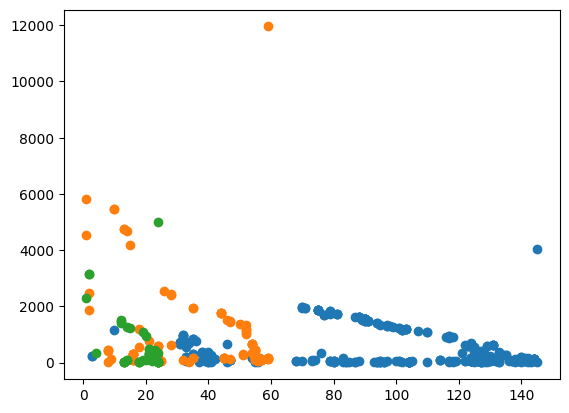

In [35]:
# step 9 : plotting points with closest_distance on x axis and local_densities on y axis

for i in clusters.keys():
  plt.scatter(local_densities[i], closest_distance[i])


In [36]:
# step 10 : Merge_POP array selection from all points

pairs = ordered_pairs(clusters.keys(),local_densities,closest_distance)

In [37]:
# this part gives us the lower and upper boundary of each and every cluster using IQR
local_density_range = []
closest_distance_range = []
for i in clusters.keys():
  local_density_range.append(outlier_range(local_densities[i]))
  closest_distance_range.append(outlier_range(closest_distance[i]))


In [38]:
# this boolean function checks if the pairs lies in our range or not
# this takes input parameters as local_density,closest_distance_range array,pair array

def check(local_density_range,closest_distance_range,keys,pair):
  cn1=0
  cn2=0
  for i in keys:
    if (pair[0] >= local_density_range[i][0] and pair[0]<=local_density_range[i][1]):
      cn1+=1
    if (pair[1])>=closest_distance_range[i][0] and pair[1]<=closest_distance_range[i][1]:
      cn2+=1
  if(cn1==0 or cn2==0):
    return True
  else:
    return False


In [39]:
# getting outliers from the
points_dict = OrderedDict()

for i in clusters.keys():
  for j in pairs[i]:
    if (check(local_density_range,closest_distance_range,clusters.keys(),j)):
      temp = pairs[i].index(j)
      val = clusters[i][temp]
      if i not in points_dict:
        points_dict[i] = [val]
      else:
        points_dict[i].append(val)



In [40]:
# probable local and global outliers from clusters using IQR
points_dict

OrderedDict([(0,
              [[1961, 6],
               [1876, 7],
               [1879, 36],
               [1370, 46],
               [1962, 9],
               [100, 3],
               [1877, 25],
               [1965, 40],
               [2002, 101],
               [33, 43],
               [1965, 40],
               [1961, 14],
               [109, 24],
               [1961, 20],
               [208, 308],
               [1990, 1],
               [1997, 3],
               [33, 43]]),
             (1,
              [[5090, 49],
               [7264, 69],
               [7023, 59],
               [4721, 17],
               [7021, 46],
               [5074, 45],
               [16188, 19],
               [8932, 632],
               [4295, 20],
               [6034, 60],
               [5083, 120],
               [11635, 64],
               [4233, 11],
               [5911, 1102],
               [4668, 32],
               [5090, 49],
               [4233, 11],
               [12251, 1

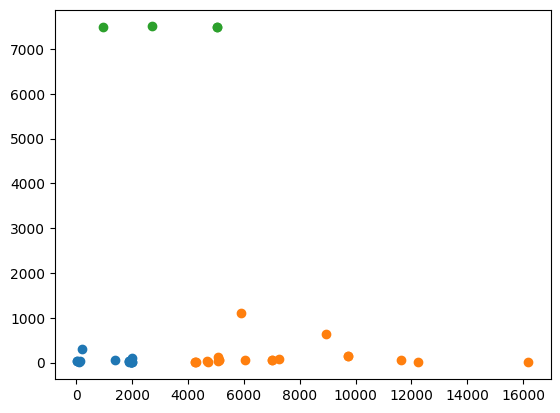

In [41]:
# plotting of outliers
for i in points_dict.keys():
  plt.scatter([k[0] for k in points_dict[i]],[k[1] for k in points_dict[i]])

In [42]:
# Storing the probable outliers in merge_pop array
merge_pop = []
for i in points_dict.keys():
  for j in points_dict[i]:
    merge_pop.append([i,clusters[i].index(j)])
merge_pop

[[0, 4],
 [0, 23],
 [0, 24],
 [0, 30],
 [0, 54],
 [0, 60],
 [0, 113],
 [0, 132],
 [0, 168],
 [0, 183],
 [0, 132],
 [0, 193],
 [0, 197],
 [0, 216],
 [0, 300],
 [0, 307],
 [0, 309],
 [0, 183],
 [1, 0],
 [1, 1],
 [1, 4],
 [1, 10],
 [1, 23],
 [1, 24],
 [1, 26],
 [1, 27],
 [1, 30],
 [1, 32],
 [1, 43],
 [1, 48],
 [1, 50],
 [1, 53],
 [1, 56],
 [1, 0],
 [1, 50],
 [1, 90],
 [1, 94],
 [1, 94],
 [2, 4],
 [2, 26],
 [2, 42],
 [2, 42]]

In [43]:
# Step 11 - calculating ODF of points
# Applying outlier selection startegy and calculating odf of all points
odf = outlier_selection_strategy_2(merge_pop,local_densities,closest_distance,std_dev,avg_distances)

In [44]:
# lets map odf values with merge_pop array

mp = OrderedDict()
for i,j in zip(odf,merge_pop):
  mp[i] = j

In [45]:
# sorting of odf
odf.sort()

In [46]:
# From these select top N
print("Total no. of outliers are  : ",len(odf)-1)
N = int(input("Enter no. of outliers u want : "))
if N>=len(odf):
  print("Entered number is more than length of outliers array")
else:
  final_outliers = []

  final_outliers_range =  OrderedDict()

  for i in odf[:N]:
      temp = mp[i]
      final_outliers.append(clusters[temp[0]][temp[1]])
      if mp[i][0] in final_outliers_range.keys():
          final_outliers_range[mp[i][0]].append(clusters[mp[i][0]][mp[i][1]])
      else:
        final_outliers_range[mp[i][0]] = [clusters[mp[i][0]][mp[i][1]]]


  print(final_outliers_range)


Total no. of outliers are  :  41
OrderedDict([(1, [[5090, 49], [5090, 49], [5083, 120], [5074, 45], [11635, 64]])])


# **Verification**

OrderedDict([(1, [[5090, 49], [5090, 49], [5083, 120], [5074, 45], [11635, 64]])])


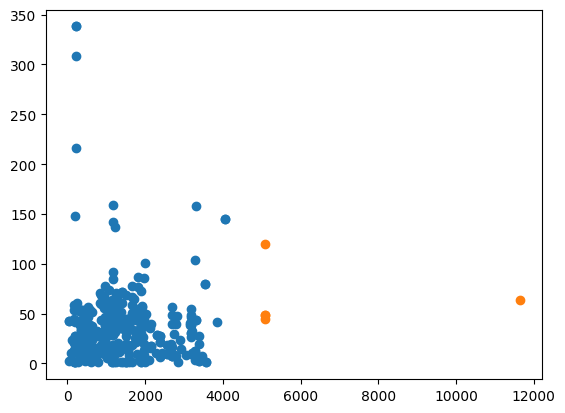

In [47]:
plt.scatter([i[0] for i in clusters[0]],[i[1] for i in clusters[0]])
plt.scatter([i[0] for i in final_outliers],[i[1] for i in final_outliers])
print(final_outliers_range)

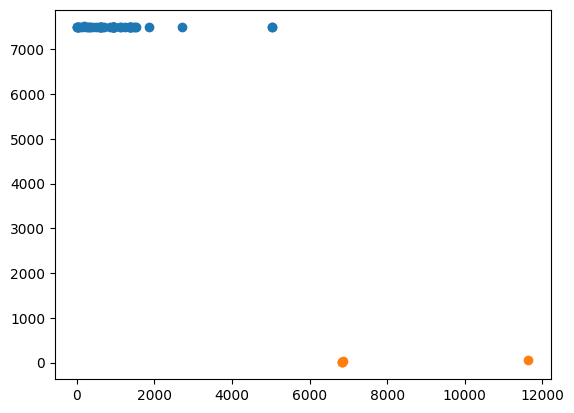

In [171]:
plt.scatter([i[0] for i in clusters[1]],[i[1] for i in clusters[1]])
plt.scatter([i[0] for i in final_outliers_range[2]],[i[1] for i in final_outliers_range[2]])

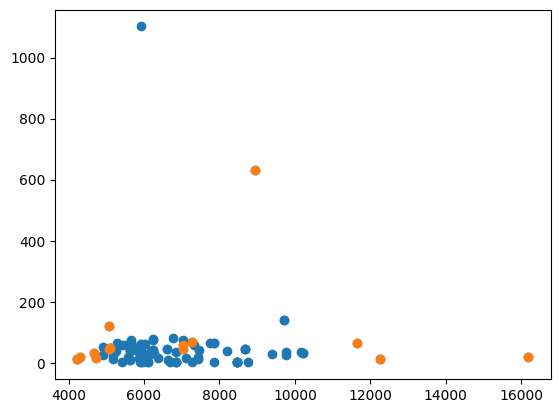

In [1125]:
plt.scatter([i[0] for i in clusters[2]],[i[1] for i in clusters[2]])
plt.scatter([i[0] for i in final_outliers_range[2]],[i[1] for i in final_outliers_range[2]])
